In [1]:
# Standard library imports
import glob
import os
import shutil
import time

# Third party imports
from matplotlib import colors
import matplotlib.pyplot as plt
import geopandas as gpd
from osgeo import gdal
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy.ndimage import generic_filter
from scipy.spatial import distance
import shapefile as shp
from shapely.geometry import Point
import vtk
import pyvista as pv
import pyemu
import pypestutils
import PEST_utils


# Flopy imports
import flopy
import flopy.utils
from flopy.discretization import StructuredGrid
from flopy.export import vtk as vtk_export
from flopy.export.shapefile_utils import *
from flopy.mf6.utils.reference import SpatialReference
from flopy.modflow import ModflowNwt, ModflowRch, ModflowStr
from flopy.utils import CellBudgetFile, Raster, ZoneBudget, binaryfile as bf
from flopy.utils.gridgen import StructuredGrid as StructuredGridGen
from flopy.utils.util_array import Util2d
from flopy.mf6.modflow.mfgwfrcha import ModflowGwfrcha
from flopy.mf6.modflow.mfgwfsfr import ModflowGwfsfr
from flopy.mf6.modflow.mfgwfriv import ModflowGwfriv
from flopy.utils import ZoneBudget6, CellBudgetFile


print("Modules imported successfully.")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Modules imported successfully.


In [2]:
import os
import shutil
import glob

# Specify the directory you want to clean up
directory = 'C:/Users/sebas/Documents/UGent/Sem 3/Thesis/GondebeekModel/Modflow_SS_master'

# Get a list of all files in the directory
all_files = glob.glob(os.path.join(directory, '*'))

# Specify the file types you want to keep
keep_patterns = ['*.py', '*.ipynb', '*.exe']

# Get a list of files to keep
keep_files = []
for pattern in keep_patterns:
    keep_files.extend(glob.glob(os.path.join(directory, pattern)))

# Specify the directories to skip
skip_directories = ['__pycache__']

# Get a list of files to delete
delete_files = set(all_files) - set(keep_files)

# Delete the files
for file in delete_files:
    # Skip the file if it's in the directories to skip
    if any(skip_dir in file for skip_dir in skip_directories):
        continue

    if os.path.isfile(file):
        os.remove(file)
    elif os.path.isdir(file):
        shutil.rmtree(file)

# Specify the source directory
source_directory = 'C:/Users/sebas/Documents/UGent/Sem 3/Thesis/GondebeekModel/Modflow_SS'

# Copy all files from the source directory to the target directory
for file in glob.glob(os.path.join(source_directory, '*')):
    # Skip the file if it's in the directories to skip
    if any(skip_dir in file for skip_dir in skip_directories):
        continue
    shutil.copy(file, directory)

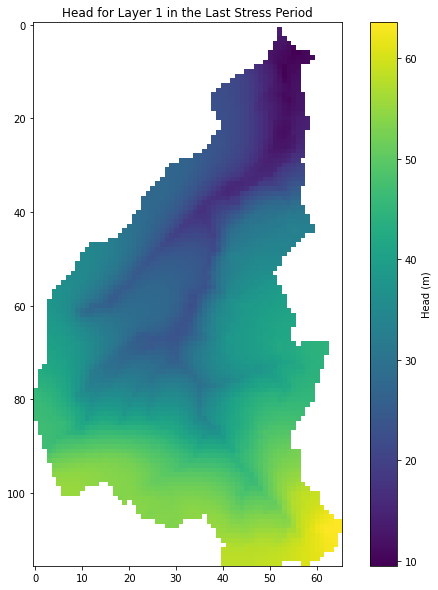

In [3]:

# Load the head data
hds = flopy.utils.HeadFile('Gondebeek_SS.hds')

# Get all times and stress periods/time steps
times = hds.get_times()
kstpkper = hds.get_kstpkper()

# Get the last time and stress period/time step
last_time = times[-1]
last_kstpkper = kstpkper[-1]

# Get the head for the last stress period and time step
head = hds.get_data(totim=last_time)

# Mask values lower than -900
head = np.ma.masked_where(head > 50000, head)

# Plot the head for layer 1
plt.figure(figsize=(10, 10))
plt.imshow(head[1, :, :], cmap='viridis', interpolation='none')
plt.colorbar(label='Head (m)')
plt.title('Head for Layer 1 in the Last Stress Period')
plt.show()

hds.close()

The number of rows is 32
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package oc...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package rch...
    loading package riv...
  loading solution package gondebeek_ss...


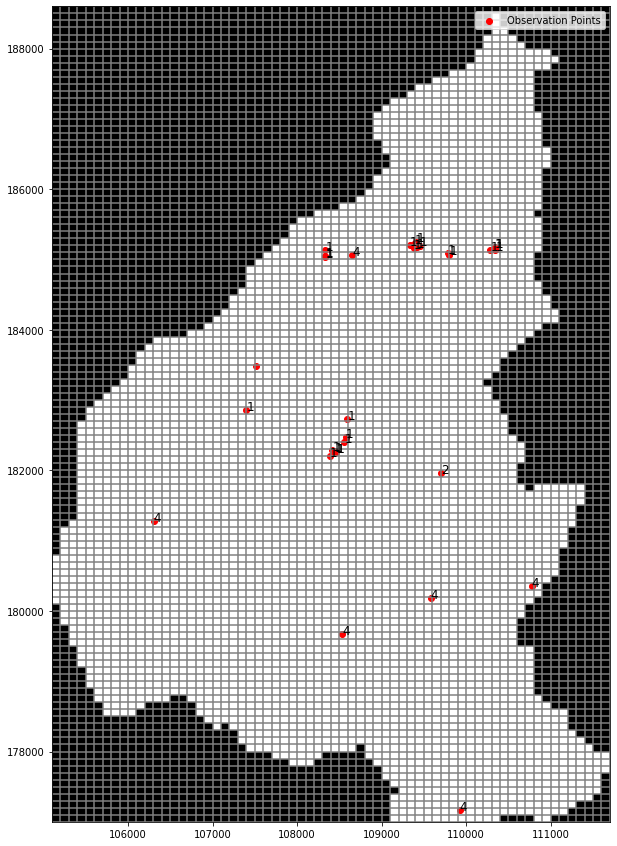

In [4]:
# Load the data
data_path = r"C:\Users\sebas\Documents\UGent\Sem 3\Thesis\GondebeekModel\Inputs\Obs\Standarized_data_in_catchment.csv"
model_path= r"C:\Users\sebas\Documents\UGent\Sem 3\Thesis\GondebeekModel\Gondebeek_SS" 
df = pd.read_csv(data_path)

# Drop the rows where 'Layer' is empty
df = df.dropna(subset=['Layer'])

num_rows = df.shape[0]
print(f'The number of rows is {num_rows}')

# Load the MODFLOW 6 model
model = flopy.mf6.MFSimulation.load(sim_name='Gondebeek_SS')

# Get the groundwater flow model from the simulation
gwf = model.get_model('Gondebeek_SS')

# Get the model's discretization package
dis = gwf.dis

# Scatter plot of observation points
fig, ax = plt.subplots(figsize=(10, 15))
modelmap = flopy.plot.PlotMapView(model=gwf, layer=0, ax=ax)
grid = modelmap.plot_grid()
ibound = modelmap.plot_ibound()
scatter = ax.scatter(df['X'], df['Y'], color='red', label='Observation Points')

# Annotate each point with its "Layer" attribute
for i, txt in enumerate(df['Layer']):
    ax.annotate(txt, (df['X'].iloc[i], df['Y'].iloc[i]), fontsize=12)  # Adjust fontsize as needed

# Show the plot
plt.legend()
plt.show()

posx and posy should be finite values


posx and posy should be finite values


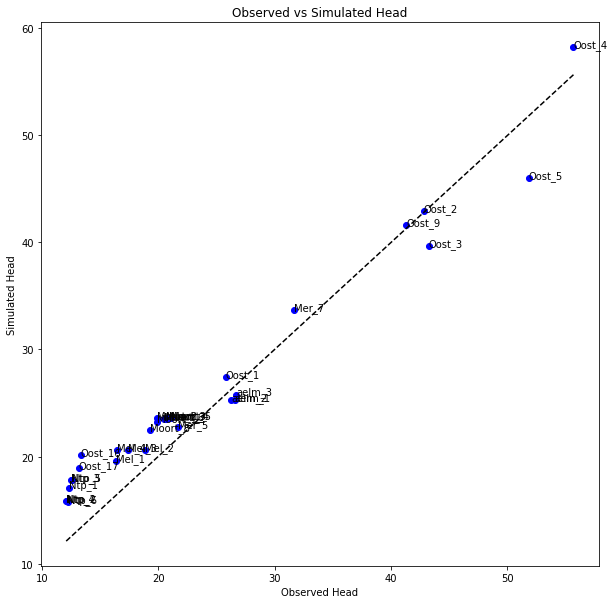

In [5]:
# Load the head data
headfile = flopy.utils.HeadFile('Gondebeek_SS.hds')
head = headfile.get_data(totim=headfile.get_times()[-1])  # Get the head data for the last SP

# Create a function to get the head value at a specific location
def get_head_at_location(x, y, layer):
    try:
        layer = int(layer) - 1  # Subtract 1 from layer
        row, col = gwf.modelgrid.intersect(x, y)  # Convert x, y to row, col
        return head[layer, int(row), int(col)]
    except ValueError:  # If layer can't be converted to an integer
        return np.nan  # Return a default value

# Apply the function to the observation points
df['Simulated_Head'] = df.apply(lambda row: get_head_at_location(row['X'], row['Y'], row['Layer']), axis=1)

# Create a scatter plot of the observed and simulated head values
plt.figure(figsize=(10, 10))
plt.scatter(df['Mean_phrea'], df['Simulated_Head'], color='blue')

# Add labels to the points
for i, point in df.iterrows():
    plt.text(point['Mean_phrea'], point['Simulated_Head'], str(point['ID']))

plt.xlabel('Observed Head')
plt.ylabel('Simulated Head')
plt.title('Observed vs Simulated Head')

# Add a line representing Y=X
plt.plot([df['Mean_phrea'].min(), df['Mean_phrea'].max()], [df['Mean_phrea'].min(), df['Mean_phrea'].max()], 'k--')

plt.show()
hds.close()

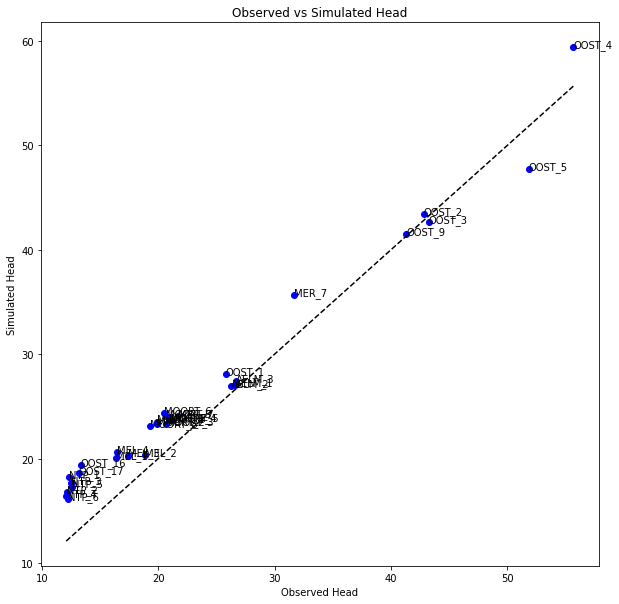

In [6]:
# Load the simulated data
simulated = pd.read_csv('simulated.smp', delim_whitespace=True, header=None, names=['ID', 'Date', 'Hour', 'Value'])

# Convert the 'ID' values in 'df' to uppercase
df['ID'] = df['ID'].str.upper()

# Merge the dataframes
df_merged = pd.merge(df, simulated, on='ID')

# Create a scatter plot of the observed and simulated head values
plt.figure(figsize=(10, 10))
plt.scatter(df_merged['Mean_phrea'], df_merged['Value'], color='blue')

# Add labels to the points
for i, point in df_merged.iterrows():
    plt.text(point['Mean_phrea'], point['Value'], str(point['ID']))

plt.xlabel('Observed Head')
plt.ylabel('Simulated Head')
plt.title('Observed vs Simulated Head')

# Add a line representing Y=X
plt.plot([df_merged['Mean_phrea'].min(), df_merged['Mean_phrea'].max()], [df_merged['Mean_phrea'].min(), df_merged['Mean_phrea'].max()], 'k--')

plt.show()

In [7]:
# Get the hydraulic conductivity array
k = gwf.npf.k.array

# Create a function to get the K value at a specific location
def get_k_at_location(x, y, layer):
    try:
        layer = int(layer) - 1  # Subtract 1 from layer
        row, col = gwf.modelgrid.intersect(x, y)  # Convert x, y to row, col
        return k[layer, int(row), int(col)]
    except ValueError:  # If layer can't be converted to an integer
        return np.nan  # Return a default value

# Create a new DataFrame with the observation points and the K values
df_k = df[['ID', 'X', 'Y', 'Layer']].copy()
df_k['K'] = df.apply(lambda row: get_k_at_location(row['X'], row['Y'], row['Layer']), axis=1)

# Filter out rows where 'Layer' cannot be converted to an integer
df_k = df_k[df_k['K'].notna()]

df_k.head()

,ID,X,Y,Layer,K
0,AELM_1,108334.1,185049.1,1,1.0
1,AELM_2,108334.0,185038.0,1,1.0
2,AELM_3,108334.8,185134.7,1,1.0
5,MEL_1,110287.0,185136.0,1,1.0
6,MEL_2,110344.0,185170.0,1,1.0


In [8]:
# Filter out rows where 'Layer' cannot be converted to an integer
df_filtered = df[pd.to_numeric(df['Layer'], errors='coerce').notna()]


# Save the 'ID', 'X', 'Y', and 'Layer' columns to a text file
df_filtered[['ID', 'X', 'Y', 'Layer']].to_csv('bore_coord.dat', sep='\t', header=False, index=False)



In [9]:
# Convert the 'ID' column to uppercase
df['ID'] = df['ID'].str.upper()

# Create a new DataFrame with the desired format
df_final = pd.DataFrame({
    'ID': df['ID'],
    'date': '01/01/2015',
    'time': '00:00:00',
    'Mean_phrea': df['Mean_phrea']
})

# Save the DataFrame to a text file with tab-separated values without the index
df_final.to_csv('observed.smp', sep='\t', index=False, header=False)

df_final.head()

,ID,date,time,Mean_phrea
0,AELM_1,01/01/2015,00:00:00,26.57
1,AELM_2,01/01/2015,00:00:00,26.29
2,AELM_3,01/01/2015,00:00:00,26.72
5,MEL_1,01/01/2015,00:00:00,16.42
6,MEL_2,01/01/2015,00:00:00,18.91


In [10]:


# Get the number of layers
nlay = gwf.modelgrid.nlay

# Create an empty 3D array for the zones
zones = np.zeros((nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=int)

# Initialize a dictionary to store the K values for each zone
zone_k_values = {}

zone_counter = 1
for layer in range(k.shape[0]):
    unique_k_values = np.unique(k[layer])
    for k_value in unique_k_values:
        zones[layer][k[layer] == k_value] = zone_counter
        zone_k_values[zone_counter] = k_value  # Store the K value for the zone
        zone_counter += 1

    # Save the zones for the current layer to a text file
    np.savetxt('zones_layer{}.txt'.format(layer+1), zones[layer], fmt='%d')
    
    


Load the model and write it as external files

In [11]:

# Load the MODFLOW 6 model
model = flopy.mf6.MFSimulation.load(sim_name='Gondebeek_SS')

model.set_all_data_external()
# Get the hydraulic conductivity array from the NPF package


# Save the hydraulic conductivity arrays to external files
k_filenames = ["k_layer{}.txt".format(i+1) for i in range(k.shape[0])]
for layer in range(k.shape[0]):
    np.savetxt(k_filenames[layer], k[layer])

# Remove the existing NPF package
gwf.remove_package('npf')

# Create a new NPF package that references the external K files
npf = flopy.mf6.ModflowGwfnpf(gwf, k=k_filenames)

npf.write(ext_file_action=k_filenames)

model.write_simulation()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package oc...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package rch...
    loading package riv...
  loading solution package gondebeek_ss...
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package gondebeek_ss...
  writing model gondebeek_ss...
    writing model name file...
    writing package dis...
    writing package oc...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package rcha_0...
    writing package riv...


Create TPL files for K. Only for the zones inside the IBOUND.

In [12]:

# Get the number of layers
nlay = gwf.modelgrid.nlay

# Initialize a dictionary to store the K values for each zone
zone_k_values = {}

# Initialize a list to store the data for the DataFrame
data = []

idomain = gwf.dis.idomain.array
zone_counter = 1
tpl_files = []  # List to store the template file names
for layer in range(k.shape[0]):
    unique_k_values = np.unique(k[layer])
    for k_value in unique_k_values:
        zones[layer][k[layer] == k_value] = zone_counter
        zone_k_values[zone_counter] = k_value  # Store the K value for the zone
        data.append([layer+1, zone_counter, k_value])  # Add the data to the list
        zone_counter += 1

    # Create a template file for the current layer
    tpl_filename = 'zones_layer{}.tpl'.format(layer+1)
    tpl_files.append(tpl_filename)  # Add the file name to the list
    with open(tpl_filename, 'w') as f:
        f.write("ptf ~\n")
        for row in range(zones[layer].shape[0]):
            for col in range(zones[layer].shape[1]):
                if idomain[layer][row][col] == 1:  # If the cell is inside the IDOMAIN
                    f.write("~{:>10}~ ".format('k'+str(zones[layer][row][col])))  # Write the parameter name
                else:  # If the cell is outside the IDOMAIN
                    f.write("{:>15} ".format("1.00000000E+00"))  # Write the K value
            f.write("\n")

# Print the list of template file names
print(tpl_files)

['zones_layer1.tpl', 'zones_layer2.tpl', 'zones_layer3.tpl', 'zones_layer4.tpl']


Create TPL file for the River package (conductance)

In [13]:
def create_tpl_file(original_file, tpl_file):
    # Read the original file
    with open(original_file, 'r') as f:
        lines = f.readlines()

    # Modify the fifth column and write to the template file
    with open(tpl_file, 'w') as f:
        f.write("ptf ~\n")  # Write the parameter transformation flag
        for line in lines:
            parts = line.split()
            parts[4] = "~        c~"  # Replace the fifth column
            f.write(' '.join(parts) + '\n')

    # Add the template file to the list
    tpl_files.append(tpl_file)

# Use the function to create the template file
create_tpl_file('Gondebeek_SS.riv_stress_period_data_1.txt', 'riv.tpl')

print(tpl_files)

['zones_layer1.tpl', 'zones_layer2.tpl', 'zones_layer3.tpl', 'zones_layer4.tpl', 'riv.tpl']


Create INS file for the observation.smp

In [14]:
# Read the 'simulated.smp' file
df = pd.read_csv('simulated.smp', sep='\s+', header=None)

# Extract the observation IDs and values
obs_ids = df[0].tolist()
values = df[3].tolist()

# Open the TPL file
with open('simulated.smp.tpl', 'w') as f:
    # Write the PIF line
    f.write('pif ~\n')

    # Write the observation IDs and values
    for obs_id, value in zip(obs_ids, values):
        f.write('l1   [HEAD_{}]55:66\n'.format(obs_id))

print("TPL file 'simulated.smp.tpl' created.")

TPL file 'simulated.smp.tpl' created.


<>:2: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
C:\Users\sebas\AppData\Local\Temp/ipykernel_24292/3999174929.py:2: DeprecationWarning: invalid escape sequence \s


In [13]:
gwf.dis.nlay.data

4

Creation of neccesary PEST files with PEST_utils

In [16]:
#instruction file for mf6mod2obs
#instruction_file = PEST_utils.mf6mod2obs_in(os.getcwd(), 'file.ntb','observed.smp' , 'Gondebeek_SS.hds', 's', gwf.dis.nlay.data, 'd', '01-01-2015', 10, 'simulated.smp')


# Delete the 'run_model.bat' file if it exists
if os.path.exists('run_model.bat'):
    os.remove('run_model.bat')

# Use the function to add instructions to the batch file
PEST_utils.addbatchfile(os.getcwd(), '@echo off', 'run_model.bat')
PEST_utils.addbatchfile(os.getcwd(), 'del Gondebeek_SS.hds', 'run_model.bat')
PEST_utils.addbatchfile(os.getcwd(), 'del Gondebeek_SS.cbc', 'run_model.bat')
PEST_utils.addbatchfile(os.getcwd(), 'mf6.exe Gondebeek_SS.nam', 'run_model.bat')
PEST_utils.addbatchfile(os.getcwd(), 'mf6mod2obs < simulated.in', 'run_model.bat')

pst=PEST_utils.pestprep1(os.getcwd(),'gondebeek_ss.pst', 'observed.smp', 'simulated.smp','prefix','head', tpl_files, 'run_model.bat')